In [4]:
import tweepy

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import re  

import spacy
nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Credentials

consumer_key = 'frxFyJskSPkPvxiMu8NKUfvX8'

consumer_secret = 'tCtujcAsHIZF8TSzDxKCBJbfM75v8vNEzClmuA48nSqpnC0PH0'

access_token = '557446265-KT2R47ApGYDLiLMDjbYTQONxhctzAtdhbZRm39SE'

access_token_secret = 'nYaLC8D3KzHPcKCRNIoNclAEiMDZ5mROmCqpZZsyheAxb'


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [12]:
user = api.get_user(screen_name='JoeBiden')


print(user.id_str)
print("The name is : " + user.name)
print("The screen_name is : " + user.screen_name)
print("The location is : " + str(user.location))
print("The profile_location is : " + str(user.profile_location))
print("The description is : " + user.description)

939091
The name is : Joe Biden
The screen_name is : JoeBiden
The location is : Washington, DC
The profile_location is : None
The description is : Husband to @DrBiden, proud father and grandfather. Ready to build back better for all Americans. Official account is @POTUS.


In [ ]:
# getting properties info in a single tweet

#for i in cursor:
    #print(dir(i))

In [24]:
number_of_tweets = 700
tweet_id = []
tweets = []
like_count = []
time = []
retweet_count = []
source = []

for i in tweepy.Cursor(api.user_timeline, screen_name='JoeBiden', tweet_mode = 'extended').items(number_of_tweets):
    tweet_id.append(i.id)
    tweets.append(i.full_text)
    like_count.append(i.favorite_count)
    time.append(i.created_at)
    retweet_count.append(i.retweet_count)
    source.append(i.source)
    
df = pd.DataFrame({'tweet_id': tweet_id, 'tweets': tweets, 'like_count': like_count, 
                   'time': time, 'retweet_count': retweet_count, 'source': source})

In [25]:
df

,tweet_id,tweets,like_count,time,retweet_count,source
0,1444310062198054921,RT @POTUS: My Build Back Better Agenda and the...,0,2021-10-02 14:35:27+00:00,1953,Sprout Social
1,1444085055031320578,"RT @POTUS: This week, I’ve been working closel...",0,2021-10-01 23:41:21+00:00,3809,Sprout Social
2,1444068124421144580,RT @POTUS: We are going to deliver for the Ame...,0,2021-10-01 22:34:05+00:00,2196,Twitter Web App
3,1443964473941925893,RT @POTUS: Let me be clear: No hardworking Ame...,0,2021-10-01 15:42:12+00:00,4736,Twitter Web App
4,1443366490158272517,We have a path to usher in a new era of econom...,30818,2021-09-30 00:06:02+00:00,4436,Sprout Social
...,...,...,...,...,...,...
695,1334582546152235008,RT @Transition46: If we are going to tackle th...,0,2020-12-03 19:37:29+00:00,1622,Twitter for iPhone
696,1334573366410264577,"Once a vaccine is ready and approved, @KamalaH...",339685,2020-12-03 19:01:00+00:00,22882,TweetDeck
697,1334530332167729154,"Yesterday, I spent the afternoon hearing from ...",51265,2020-12-03 16:10:00+00:00,4183,Twitter Media Studio
698,1334306493328470017,RT @Transition46: .@NeeraTanden understands th...,0,2020-12-03 01:20:32+00:00,2135,Twitter Web App


In [26]:
# removing the retweets (Note that ~ tilda is the not operator)

df = df[~df.tweets.str.contains("RT")]

df

,tweet_id,tweets,like_count,time,retweet_count,source
4,1443366490158272517,We have a path to usher in a new era of econom...,30818,2021-09-30 00:06:02+00:00,4436,Sprout Social
6,1443332006742568967,The Bipartisan Infrastructure Deal and the Bui...,22624,2021-09-29 21:49:00+00:00,3339,Sprout Social
7,1443286545608454153,This is the moment to make sure all of us—not ...,21008,2021-09-29 18:48:22+00:00,3160,Sprout Social
8,1442984974328627203,Our Build Back Better Agenda will strengthen o...,15681,2021-09-28 22:50:01+00:00,2328,Sprout Social
9,1442965340653121537,"As my friend, American hero Representative Joh...",27617,2021-09-28 21:32:00+00:00,4306,Sprout Social
...,...,...,...,...,...,...
693,1334673525655830528,It’s time we reward hard work in America — not...,302637,2020-12-04 01:39:00+00:00,17020,TweetDeck
694,1334647856645500929,On this International Day of People with Disab...,92252,2020-12-03 23:57:00+00:00,8047,TweetDeck
696,1334573366410264577,"Once a vaccine is ready and approved, @KamalaH...",339685,2020-12-03 19:01:00+00:00,22882,TweetDeck
697,1334530332167729154,"Yesterday, I spent the afternoon hearing from ...",51265,2020-12-03 16:10:00+00:00,4183,Twitter Media Studio


In [27]:
x = df[df.tweets.str.contains('economy')]

x

,tweet_id,tweets,like_count,time,retweet_count,source
6,1443332006742568967,The Bipartisan Infrastructure Deal and the Bui...,22624,2021-09-29 21:49:00+00:00,3339,Sprout Social
7,1443286545608454153,This is the moment to make sure all of us—not ...,21008,2021-09-29 18:48:22+00:00,3160,Sprout Social
8,1442984974328627203,Our Build Back Better Agenda will strengthen o...,15681,2021-09-28 22:50:01+00:00,2328,Sprout Social
13,1442600939022602243,The wealthy don’t need another tax cut. Our Bu...,22313,2021-09-27 21:24:00+00:00,3183,Sprout Social
19,1442220684407676929,Millionaires and billionaires are paying a low...,52936,2021-09-26 20:13:00+00:00,7332,Sprout Social
26,1441803436291416069,"For too long, our economy has worked great for...",23675,2021-09-25 16:35:01+00:00,3345,Sprout Social
27,1441542463613718528,"Folks, we’re facing an urgent choice: do we ke...",33529,2021-09-24 23:18:00+00:00,4850,Sprout Social
40,1439975893250740225,Our Build Back Better Agenda will invest in wo...,17445,2021-09-20 15:33:01+00:00,2574,Sprout Social
44,1438987881545076738,We can build an economy that gives working peo...,15680,2021-09-17 22:07:00+00:00,2159,Sprout Social
63,1436490934770929706,Our new COVID-19 plan will reduce the number o...,39645,2021-09-11 00:45:02+00:00,4850,Sprout Social


In [28]:
y = df[df.tweets.str.contains('jobs')]

y

,tweet_id,tweets,like_count,time,retweet_count,source
6,1443332006742568967,The Bipartisan Infrastructure Deal and the Bui...,22624,2021-09-29 21:49:00+00:00,3339,Sprout Social
20,1442184451362988034,Our Build Back Better Agenda will cut taxes fo...,20518,2021-09-26 17:49:02+00:00,3364,Sprout Social
35,1440428877822660608,"As we recover from this crisis, we must put in...",11216,2021-09-21 21:33:01+00:00,1584,Sprout Social
45,1438944345881812999,Our Build Back Better agenda takes on the exis...,13163,2021-09-17 19:14:01+00:00,1820,Sprout Social
68,1435999951230840842,The Bipartisan Infrastructure Deal and the Bui...,10756,2021-09-09 16:14:02+00:00,1798,Sprout Social
111,1423802823192481797,"Big news: In total, our administration has cre...",20386,2021-08-07 00:27:00+00:00,2314,Sprout Social
116,1423350890354905088,We’ve made historic economic progress and crea...,17253,2021-08-05 18:31:11+00:00,1843,Sprout Social
118,1422678412200710148,Workers shouldn’t just compete for jobs. Jobs ...,13256,2021-08-03 21:59:00+00:00,1674,Twitter Media Studio
130,1418717115834642433,.@TerryMcAuliffe is running for governor of Vi...,9088,2021-07-23 23:38:13+00:00,1778,Twitter Media Studio
151,1411340208705097734,Over 300 million shots administered.\nChecks d...,53106,2021-07-03 15:05:01+00:00,5731,Sprout Social


In [29]:
#Dory was here
#This splits all the sentences up which makes it easier for us to work with

list_of_sentences = [sentence for sentence in df.tweets]

lines=[]

for sentence in list_of_sentences:
    words = sentence.split()
    for w in words:
        lines.append(w)

print(lines)

['We', 'have', 'a', 'path', 'to', 'usher', 'in', 'a', 'new', 'era', 'of', 'economic', 'growth', 'that', 'benefits', 'everybody,', 'not', 'just', 'those', 'at', 'the', 'top,', 'with', 'the', 'Build', 'Back', 'Better', 'Agenda', 'and', 'Bipartisan', 'Infrastructure', 'Deal.', 'The', 'Bipartisan', 'Infrastructure', 'Deal', 'and', 'the', 'Build', 'Back', 'Better', 'Agenda', 'will', 'create', 'good-paying', 'jobs', 'and', 'lower', 'costs', 'for', 'families.', 'Together', 'they', 'will', 'grow', 'the', 'economy', 'for', 'everybody.', 'This', 'is', 'the', 'moment', 'to', 'make', 'sure', 'all', 'of', 'us—not', 'just', 'the', 'wealthy', 'few', 'at', 'the', 'top—are', 'dealt', 'in', 'and', 'share', 'the', 'benefits', 'of', 'a', 'growing', 'economy.', 'This', 'is', 'our', 'opportunity', 'to', 'not', 'just', 'build', 'back,', 'but', 'build', 'back', 'better', 'for', 'all', 'Americans.', 'Our', 'Build', 'Back', 'Better', 'Agenda', 'will', 'strengthen', 'our', 'economy', 'by', 'lowering', 'taxes', '

In [30]:
#Removing Punctuation
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]

lines

lines2 = []

for word in lines:
    if word != '':
        lines2.append(word)

In [31]:
#This is stemming the words to their root
from nltk.stem.snowball import SnowballStemmer

# The Snowball Stemmer requires that you pass a language parameter
s_stemmer = SnowballStemmer(language='english')

stem = []
for word in lines2:
    stem.append(s_stemmer.stem(word))
    
stem

['we',
 'have',
 'a',
 'path',
 'to',
 'usher',
 'in',
 'a',
 'new',
 'era',
 'of',
 'econom',
 'growth',
 'that',
 'benefit',
 'everybodi',
 'not',
 'just',
 'those',
 'at',
 'the',
 'top',
 'with',
 'the',
 'build',
 'back',
 'better',
 'agenda',
 'and',
 'bipartisan',
 'infrastructur',
 'deal',
 'the',
 'bipartisan',
 'infrastructur',
 'deal',
 'and',
 'the',
 'build',
 'back',
 'better',
 'agenda',
 'will',
 'creat',
 'goodpay',
 'job',
 'and',
 'lower',
 'cost',
 'for',
 'famili',
 'togeth',
 'they',
 'will',
 'grow',
 'the',
 'economi',
 'for',
 'everybodi',
 'this',
 'is',
 'the',
 'moment',
 'to',
 'make',
 'sure',
 'all',
 'of',
 'usnot',
 'just',
 'the',
 'wealthi',
 'few',
 'at',
 'the',
 'topar',
 'dealt',
 'in',
 'and',
 'share',
 'the',
 'benefit',
 'of',
 'a',
 'grow',
 'economi',
 'this',
 'is',
 'our',
 'opportun',
 'to',
 'not',
 'just',
 'build',
 'back',
 'but',
 'build',
 'back',
 'better',
 'for',
 'all',
 'american',
 'our',
 'build',
 'back',
 'better',
 'agenda

In [32]:
#Removing all Stop Words

stem2 = []

for word in stem:
    if word not in nlp.Defaults.stop_words:
        stem2.append(word)

stem2

['path',
 'usher',
 'new',
 'era',
 'econom',
 'growth',
 'benefit',
 'everybodi',
 'build',
 'better',
 'agenda',
 'bipartisan',
 'infrastructur',
 'deal',
 'bipartisan',
 'infrastructur',
 'deal',
 'build',
 'better',
 'agenda',
 'creat',
 'goodpay',
 'job',
 'lower',
 'cost',
 'famili',
 'togeth',
 'grow',
 'economi',
 'everybodi',
 'moment',
 'sure',
 'usnot',
 'wealthi',
 'topar',
 'dealt',
 'share',
 'benefit',
 'grow',
 'economi',
 'opportun',
 'build',
 'build',
 'better',
 'american',
 'build',
 'better',
 'agenda',
 'strengthen',
 'economi',
 'lower',
 'tax',
 'work',
 'middl',
 'class',
 'reduc',
 'cost',
 'child',
 'care',
 'hous',
 'higher',
 'educ',
 'grow',
 'economi',
 'middl',
 'friend',
 'american',
 'hero',
 'repres',
 'john',
 'lewi',
 'remind',
 'short',
 'befor',
 'pass',
 'democraci',
 'state',
 'act',
 'nation',
 'voter',
 'registr',
 'day',
 'everi',
 'day',
 'commit',
 'defend',
 'strengthen',
 'expand',
 'sacr',
 'right',
 'vote',
 'year',
 '55',
 'largest',


In [51]:
df = pd.DataFrame(stem2)

df = df[0].value_counts()

#df
#df['freq'] = df.groupby(0)[0].transform('count')
#df['freq'] = df.groupby(0)[0].transform('count')
#df.sort_values(by = ('freq'), ascending=False)

df

american              109
work                   80
vaccin                 70
day                    64
peopl                  59
                     ... 
kwanzaa                 1
httpstco3cykhoro0h      1
punish                  1
rais                    1
httpstco3hfa0xnnfn      1
Name: 0, Length: 1723, dtype: int64

In [43]:
#This will give frequencies of our words

from nltk.probability import FreqDist

freqdoctor = FreqDist()

for words in df:
    freqdoctor[words] += 1

freqdoctor

FreqDist({55: 2, 45: 2, 36: 2, 109: 1, 80: 1, 70: 1, 64: 1, 59: 1, 58: 1, 57: 1, ...})

In [35]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

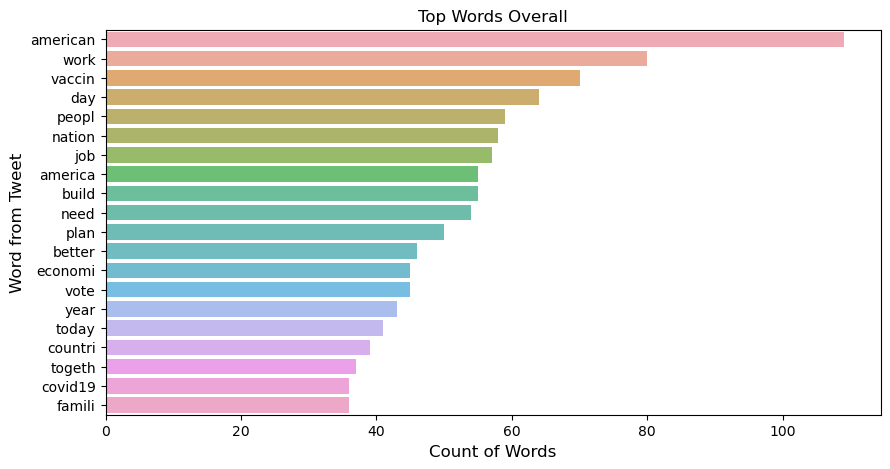

In [54]:
#This is a simple plot that shows the top 20 words being used
#df.plot(20)

df = df[:20,]
plt.figure(figsize=(10,5))

x=df.values 
y=df.index
data = pd.DataFrame({'x': x, 'y': y})

sns.barplot(x = 'x', y = 'y', alpha=0.8, data=data)

plt.title('Top Words Overall')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()



In [58]:
import spacy
from spacy import displacy
from collections import Counter

#Did not use import en_core_web_sm and nlp = en_core_web_sm.load(), because my computer couldn't find them installed. 
#Used the large size model (en_core_web_lg) imported earlier instead (in first cell), since the large model is supposed to be more accurate anyway.

In [59]:
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text + ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label_)))

In [60]:
str1 = " " 
stem2 = str1.join(lines2)

stem2 = nlp(stem2)

label = [(X.text, X.label_) for X in stem2.ents]

df6 = pd.DataFrame(label, columns = ['Word','Entity'])

df7 = df6.where(df6['Entity'] == 'ORG')

df7 = df7['Word'].value_counts()



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


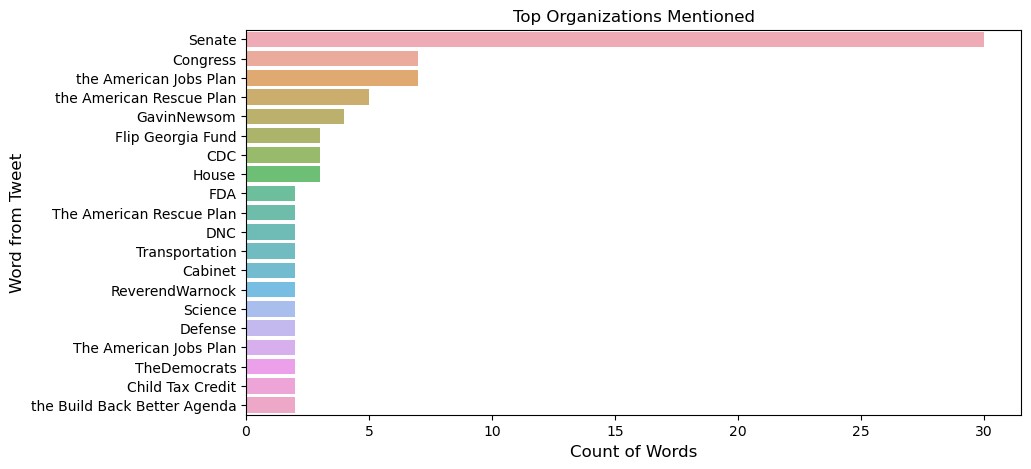

In [61]:
df = df7[:20,]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top Organizations Mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()



In [62]:
str1 = " " 
stem2 = str1.join(lines2)

stem2 = nlp(stem2)

label = [(X.text, X.label_) for X in stem2.ents]

df10 = pd.DataFrame(label, columns = ['Word','Entity'])

df10 = df10.where(df10['Entity'] == 'PERSON')

df11 = df10['Word'].value_counts()



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


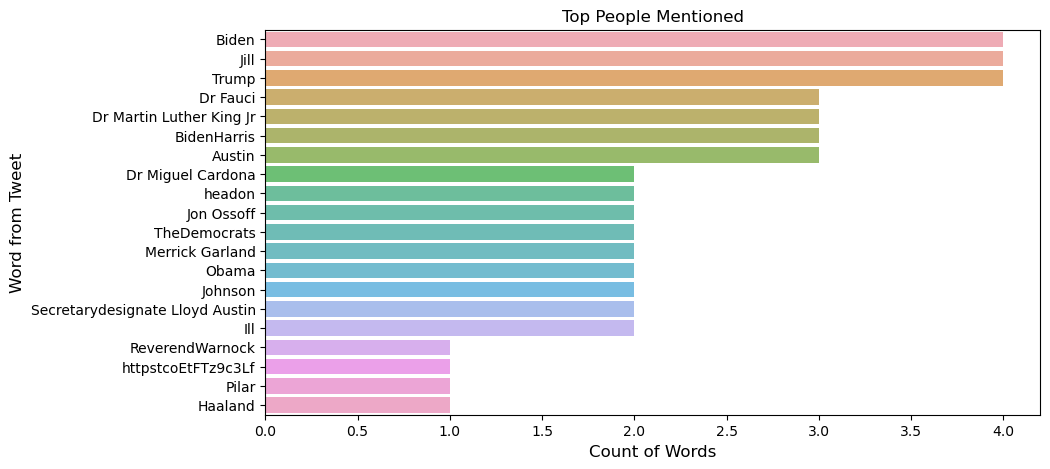

In [63]:
df = df11[:20,]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top People Mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

